In [37]:
import scanpy as sc
import numpy as np
import pandas as pd
import gc
from pathlib import Path

from matplotlib import rcParams
import matplotlib.pyplot as plt

In [2]:
path_data='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/'

In [33]:
# Saving figures
path_fig='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/figures/paper/'
sc._settings.ScanpyConfig.figdir=Path(path_fig)

In [76]:
# Load cell info (annotation, colors, category order)
adata_anno=sc.read(path_data+'data_integrated_analysed.h5ad',backed='r')
obs=adata_anno.obs.copy()
uns=adata_anno.uns.copy()
ct_cmap=dict(zip(obs.cell_type_integrated_v2.cat.categories,
                uns['cell_type_integrated_v2_colors'].copy()))
ct_cmap={obs.query('cell_type_integrated_v2==@ct')['cell_type_integrated_v2_parsed'][0]:c 
        for ct,c in ct_cmap.items()}
uns['cell_type_integrated_v2_parsed_colors']=[
    ct_cmap[c] for c in obs.cell_type_integrated_v2_parsed.cat.categories]
obsm=adata_anno.obsm.copy()
del adata_anno
gc.collect()

20830

In [20]:
# Load raw expression and subset to genes used for integration
adata=sc.read(path_data+'data_integrated_annotated.h5ad')
adata=adata.raw[:,list(adata.var.query('used_integration').index)].to_adata()

gc.collect()

557

In [71]:
# Add parsed cell info for plotting
adata.obs=obs.loc[adata.obs_names,:].copy()
adata.uns=uns.copy()

In [24]:
# Normalize and scale data
# Here normalization is performed on only HVGs, which may not be fully appropriate,
# but since we use that only for PCA and no downstream analysis this approximation
# should be fine as uses less mem&time
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.scale(adata,max_value=10)

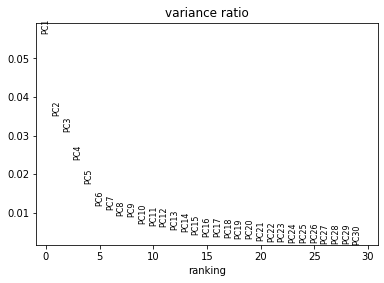

In [27]:
# PCA embedding for neihbors and UMAP computation
sc.pp.pca(adata, n_comps=30, use_highly_variable=False, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata)

In [28]:
# UMAP
sc.pp.neighbors(adata,n_pcs = 15) 
sc.tl.umap(adata)

In [31]:
# Save UMAP
if False:
    pd.DataFrame(adata.obsm['X_umap'],index=adata.obs_names).to_csv(
        path_data+'umap_unintegrated.tsv',sep='\t')

In [72]:
# Reload UMAP
if False:
    adata.obsm['X_umap']=pd.read_table(
        path_data+'umap_unintegrated.tsv',index_col=0).loc[adata.obs_names,:].values

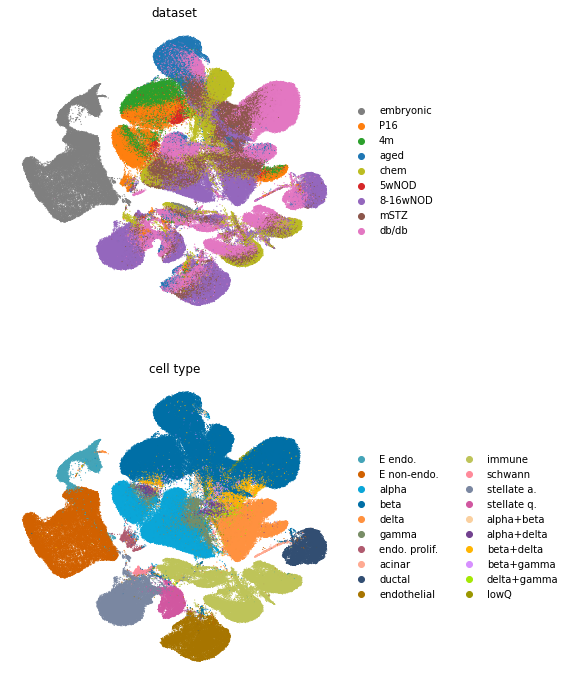

In [74]:
# Plot cell types and datasets
cols={'study_parsed':'dataset','cell_type_integrated_v2_parsed':'cell type'}
fig,ax=plt.subplots(len(cols),1,figsize=(6,6*len(cols)))
np.random.seed(0)
random_indices=np.random.permutation(list(range(adata.shape[0])))
for idx,(col,title) in enumerate(cols.items()):
    sc.pl.umap(adata[random_indices,:],color=col, ncols=1,
               s=5,hspace=0.7,
              title=title,
              frameon=False, ax=ax[idx],show=False)
#fig.tight_layout()
plt.savefig(path_fig+'umap_atlas_unintegrated.png',dpi=300,bbox_inches='tight')